### **Introduction to the project:**

#### **Core Idea:**

*The genesis of this project stemmed from my aspiration to engage with financial data and instruments. However, the lack of openly available information prompted me to embark on a journey to create my own dataset. Leveraging Python and the Bybit documentation, I crafted a trading bot capable of simulating trades—entering and exiting positions based on predefined conditions.*

*Despite the financial constraints that prevented me from executing real orders, the bot's ability to mimic trade actions provided valuable insights. The project encompasses approximately 3000 lines of code, representing around 1500 simulated trades. Subsequently, I refined strategies, adding another 1000+ lines, focusing on more effective trading approaches.*

*It's crucial to emphasize that the strategies implemented in this project are rudimentary and intended solely for educational purposes.* *Real-world markets demand a more nuanced approach to analysis and bot development.*

*The simplicity of my strategies stems from the necessity to generate a high volume of trades within a limited timeframe. Nevertheless, these* *strategies can be enhanced for precision and potentially applied in real-market scenarios.*

#### **Objectives:**

*The primary goal of this project is to evaluate the long-term viability of the implemented strategies. Can these strategies yield profits despite their simplicity?*

#### **Tasks:**

**Data Preprocessing:**
*Conduct a comprehensive preprocessing of the dataframe to ensure data quality.*

**Profit Assessment for Each Strategy:**
*Evaluate the profit generated by each strategy to gauge their effectiveness.*

**Frequency Distribution Analysis:**
*Examine the frequency distribution of strategies to understand their prevalence.*

**Detailed Coin-wise Distribution:**
*Explore the distribution of trades across different coins for a more granular analysis.*

**Percentage of Positive Trades:**
*Calculate the percentage of positive trades to assess the overall success rate.*

**Calculation of Expected Value:**
*Compute the mathematical expectation to estimate the prospects of each strategy.*

**A/B Testing for Improved Strategies:**
*Conduct A/B testing to compare the performance of enhanced strategies against standard ones.*

**Statistical Significance Test:**
*Perform statistical significance tests to validate the reliability of observed differences.*

**Comparison of Profit and Success Rates:**
*Compare the profits and percentage of positive trades between improved and standard strategies.*

**Analysis of Stop Loss to Take Profit Ratio:**
*Evaluate the ratio of stop losses to take profits for both improved and standard strategies.*

*In conclusion, this project endeavors to dissect the intricacies of trading strategies, aiming to ascertain their profitability over an extended period. The ensuing analysis and tests will provide valuable insights into the efficacy of these strategies, guiding potential future improvements for real-world application.*

### **Main Section.**

*Importing necessary libraries.*

In [1621]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image
plt.style.use('dark_background')

*Reading an xlsx file*

In [1622]:
df = pd.read_excel('Common Bybit Data.xlsx')

### **Performing preprocessing of data before analysis.**

*Our data has spaces. let's delete them.*

*Additionally, I want to delete the ID since my program cannot run continuously.* 

*Each time I run the program, the IDs are reset. That's why I also delete them. IDs cannot assist in the analysis.*

In [1623]:
def strip_spaces(data):
    for i in data:
        data[i] = data[i].apply(lambda x: (x.strip(' ') if isinstance(x, str) else x))
    return data

df = strip_spaces(df)
df = df.drop('Order_id', axis=1)

*Now, I will divide it into two types: where we have open positions and where we have closed positions, so that I can merge them later.*

In [1624]:
df_open_position = df[df['Order_type'] == 'OPEN']
df_close_position = df[df['Order_type'] == 'CLOSE']

*Next, drop unnecessary columns from our dataframes.*

In [1625]:
df_open_position = df_open_position.drop('None.3', axis = 1)

df_open_position =df_open_position.rename(columns={'None': 'Price', 'None.1': 'Date', 'None.2': 'Time'})

df_close_position = df_close_position.rename(columns={'None': 'Tp/Sl', 'None.1': 'Price', 'None.2': 'Date', 'None.3': 'Time'})

*Standardize our columns to a common format*

In [1626]:
def to_main_format(data):
    data['Price'] = data['Price'].astype(float)
    data['Date'] = data['Date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
    data['Time'] = data['Time'].apply(lambda x: pd.to_datetime(x[:-1], format='%H:%M:%S')).dt.time
    return data

df_open_position = to_main_format(df_open_position)
df_close_position = to_main_format(df_close_position)

*This is a very interesting function below.*

*It breaks down the entire dataframe into smaller dataframes. A 'row_num' column is added to each of these smaller dataframes, which is then used to merge these small dataframes, thereby excluding situations where, for example, we have an open position but no closed position, or, for example, when pairs are incorrectly joined because of the absence of trade IDs, making it challenging to connect them. This applies to many other scenarios as well. The merged dataframes are then combined with similar ones, resulting in a correct dataframe with proper connections, where each trade has its corresponding pair.*

*The sequence is as follows:*

*def all_strategies ---> def all_coins_orders ---> def all_coin_orders ---> def buy_and_sell_orders*

*def all_strategies <--- def all_coins_orders <--- def all_coin_orders <---  def buy_and_sell_orders*

In [1627]:
def add_row_num(x):
    x['row_num'] = range(len(x))
    return x

def buy_and_sell_orders(data, strategy, coin):
    data = data[data['Num_strategy'] == strategy]
    buy = data[(data['Coin'] == coin) & (data['Side'] ==  'BUY')].copy()
    sell = data[(data['Coin'] == coin) & (data['Side'] ==  'SELL')].copy()
    return buy, sell

def all_coin_orders(data1, data2, coin, strategy):
    #orders[0] - open Buy || orders[1] - open sell || orders[2] - close buy || orders[3] - close sell
    orders = [*buy_and_sell_orders(data1,strategy, coin), *buy_and_sell_orders(data2,strategy, coin)]
    for i in range(len(orders)):
        orders[i] = add_row_num(orders[i])
    df = pd.concat([orders[0].merge(orders[3], on = 'row_num'),orders[1].merge(orders[2], on = 'row_num')])
    return df

def all_coins_orders(data1, data2, strategy):
    coins = data1[data1['Coin'].notna()]['Coin'].unique()
    df = all_coin_orders(data1, data2, coins[0], strategy)
    for coin in coins[1:]:
        df = pd.concat([df,all_coin_orders(data1, data2, coin, strategy)])
    return df

def all_strategies(data1, data2):
    strategies = data1[data1['Num_strategy'].notna()]['Num_strategy'].unique()
    df = all_coins_orders(data1, data2, strategies[0])
    for strategy in strategies[1:]:
        df = pd.concat([df, all_coins_orders(data1, data2, strategy)])
    return df


df = all_strategies(df_open_position, df_close_position)


*Let's format everything nicely and enjoy our finalized dataframe.*

In [1628]:
df = df.drop(columns=['row_num', 'Num_strategy_y', 'Coin_y', 'Date_y', 'Order_type_x', 'Order_type_y'])
df = df[['Num_strategy_x', 'Coin_x', 'Date_x', 'Side_x', 'Price_x','Time_x', 'Side_y', 'Price_y', 'Time_y', 'Tp/Sl']]
df.columns = ['Strategy','Coin','Date','Open_side','Open_price','Open_time', 'Close_side', 'Close_price', 'Close_time', 'Result']
df.head(10)

,Strategy,Coin,Date,Open_side,Open_price,Open_time,Close_side,Close_price,Close_time,Result
0,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.703,17:59:18,SELL,15.699,17:59:18,STOP LOSS
1,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.571,18:34:04,SELL,15.569,18:34:04,STOP LOSS
2,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.484,18:43:04,SELL,15.478,18:43:14,STOP LOSS
3,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.468,19:54:00,SELL,15.462,19:54:31,STOP LOSS
4,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.452,19:59:09,SELL,15.472,20:00:43,TAKE PROFIT
5,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.461,20:01:04,SELL,15.481,20:02:26,TAKE PROFIT
6,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.506,20:17:01,SELL,15.502,20:17:53,STOP LOSS
7,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.491,20:26:07,SELL,15.511,20:26:28,TAKE PROFIT
8,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.549,20:40:03,SELL,15.569,20:47:57,TAKE PROFIT
9,FIRST STRATEGY,LINKUSDT,2024-01-21,BUY,15.562,20:52:07,SELL,15.551,20:53:51,STOP LOSS


### **A brief preface.**

**To begin with, I would like to share the strategies I have employed.**

*I want to warn you right away that these strategies are very simple, and I wouldn't recommend them for trading.*

*I needed a database that I could work with, so the conditions for the trading robot were kept uncomplicated, providing enough trades for analysis.*

#### **First strategy.**

*Several identical high or low prices.* 

*The entry condition for a trade is when two candles have either the same high or the same low.*

*This may suggest the presence of a limit seller at a specific level, absorbing buyer orders to accumulate a position for a downward move.*

*The trade is extremely short-term.*

*The stop-loss is set beyond this level, and the take-profit is based on the average price movement within 1 minute (i.e., the average candle body from this level).*

In [1629]:
Image(url ='https://i.postimg.cc/cLXLNFb3/Screenshot-3.png', width=550, height = 400)

#### **Second strategy.**

*Increased volume + trend.*

*For this strategy, I monitored the average candle volume every hour and calculated the trend based on all candles from the last 24 hours.*
 
*Entry into a trade occurred when a candle exhibited increased volume, suggesting interest from one of the parties (buyers/sellers) wanting to push the price in a certain direction. Entry was also aligned with the trend and the direction of price movement.*

*The stop-loss for the trade was placed behind the candle, while the take-profit was set at 2 average candles from the last hour in the direction of volumes.*

In [1630]:
Image(url ='https://i.postimg.cc/W121KBXj/Screenshot-1.png', width=550, height = 400)

#### **Third strategy.**

*Absorption. Entry into a trade occurs when one candle significantly surpasses another candle and engulfs it.*

*This engulfing can suggest strength in the current candle, potentially leading to a significant movement in its direction.*

*Stop-loss is set behind the current candle, and take-profit is determined as 2 average price movements within 1 minute (2 average candle bodies).*

In [1631]:
Image(url ='https://i.postimg.cc/hGvP4Vk5/Screenshot-2.png', width=550, height = 400)

### **The analysis of the dataframe.**

*Now let's proceed to the analysis.*

*It would be interesting to know the distribution by the number of transactions. This would give us a general overview of the frequency of strategies.*

**Hypothesis:**

The first strategy will have the most transactions.

*To do this, let's plot the distribution based on strategies.*

(array([680.,   0., 593.,   0., 223.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

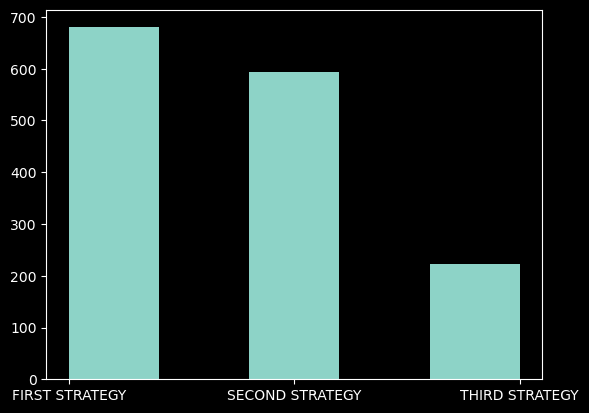

In [1632]:
plt.hist(df['Strategy'], bins = 5)

*Yes, we were correct.*

*It's quite logical, considering that we trade on a one-minute timeframe, and the probability of having two identical highs or lows is relatively high.*

### **Profit**


*Let's move on to the most interesting part and calculate which of the algorithms performed the best.*

**Hypothesis:**

*The first strategy has the highest profit.*

*To begin with, in order to refute or confirm the hypothesis, let's transform the numbers for ease of calculations.*

*If we think logically, when we buy something, it means we are giving away money, and when we sell, it means we are receiving money. Let's make adjustments:*

In [1633]:
def to_correct_price(data, x, y):
    data[x] = data[x].apply(lambda x: -1 if x == 'BUY' else 1)
    data[y] = data[x]*data[y]    
    return data

df = to_correct_price(df, 'Open_side', 'Open_price')
df = to_correct_price(df, 'Close_side', 'Close_price')

df.head(5)

,Strategy,Coin,Date,Open_side,Open_price,Open_time,Close_side,Close_price,Close_time,Result
0,FIRST STRATEGY,LINKUSDT,2024-01-21,-1,-15.703,17:59:18,1,15.699,17:59:18,STOP LOSS
1,FIRST STRATEGY,LINKUSDT,2024-01-21,-1,-15.571,18:34:04,1,15.569,18:34:04,STOP LOSS
2,FIRST STRATEGY,LINKUSDT,2024-01-21,-1,-15.484,18:43:04,1,15.478,18:43:14,STOP LOSS
3,FIRST STRATEGY,LINKUSDT,2024-01-21,-1,-15.468,19:54:00,1,15.462,19:54:31,STOP LOSS
4,FIRST STRATEGY,LINKUSDT,2024-01-21,-1,-15.452,19:59:09,1,15.472,20:00:43,TAKE PROFIT


*Now, let's adjust our results because our bot traded futures, allowing both short and long positions.*

*Therefore, there might be a discrepancy in the results.*

In [1634]:
def to_correct_result(data):
    data['Right_result'] = data['Open_price'] + data['Close_price']
    data['Right_result'] = data['Right_result'].apply(lambda x: 'TAKE PROFIT' if x>0 else 'STOP LOSS')
    data['Result'] = data['Right_result']
    data = data.drop('Right_result', axis = 1)
    return data


df = to_correct_result(df)

*Let's add the Profit right away to make calculations easier later.*

In [1635]:
df['Profit'] = df['Open_price'] + df['Close_price']

*Let's group this and get the final result.*

In [1663]:
df_test = df.groupby(['Strategy', 'Coin'])['Profit'].sum().reset_index()

df_test_ = df_test.pivot(index = 'Strategy', columns = 'Coin', values = 'Profit')

df_test_

Coin,API3USDT,ARBUSDT,DOGEUSDT,LINKUSDT,UMAUSDT
Strategy,,,,,
FIRST STRATEGY,-0.1040,0.04190,0.001940,0.347,-0.3140
SECOND STRATEGY,0.2390,-0.09110,-0.009690,-0.598,-0.7040
THIRD STRATEGY,-0.0634,0.03102,-0.000588,0.149,-0.7357


<Axes: xlabel='Coin', ylabel='Strategy'>

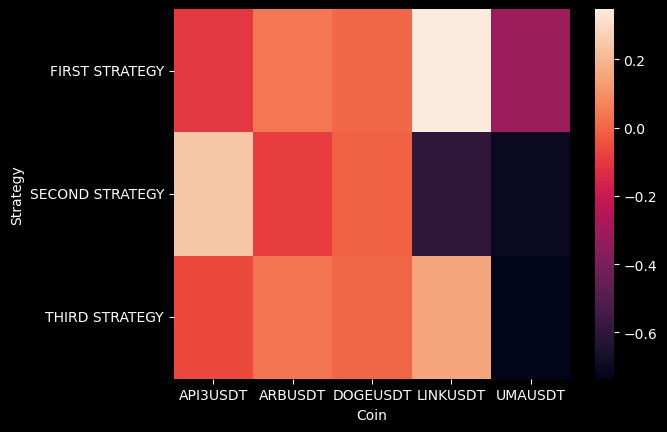

In [1664]:
sns.heatmap(df_test_)

In [1665]:
df_test = df_test.groupby(['Strategy'])['Profit'].sum().reset_index().sort_values(by = 'Profit', ascending=False)
df_test

,Strategy,Profit
0,FIRST STRATEGY,-0.027160
2,THIRD STRATEGY,-0.619668
1,SECOND STRATEGY,-1.163790


*Here, everything is clear. My hypothesis has been confirmed. In the end, the simplest strategy performed the best.*

#### **Distribution by the number of trades for each coin.**

*Now, I want to examine the distribution of the number of trades on these coins' data.*

In [1639]:
df_test = df.groupby(['Strategy', 'Coin'])['Result'].count().reset_index()
df_test = df_test.pivot(index = 'Strategy', columns = 'Coin', values = 'Result')
df_test

Coin,API3USDT,ARBUSDT,DOGEUSDT,LINKUSDT,UMAUSDT
Strategy,,,,,
FIRST STRATEGY,222,92,154,116,96
SECOND STRATEGY,98,114,138,127,116
THIRD STRATEGY,45,46,42,55,35


<Axes: xlabel='Coin', ylabel='Strategy'>

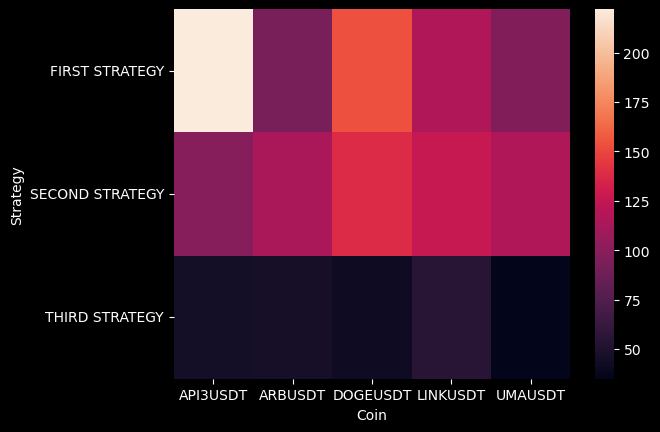

In [1640]:
sns.heatmap(df_test)

*It's evident that the most active strategy is the first one, while the most passive one is the third strategy.*

### **The percentage of positive trades.**


*It would be interesting to examine the percentage of positive and negative trades in each strategy.*

In [1641]:
df_test = df.groupby(['Strategy', 'Coin', 'Result'])['Date'].count().reset_index().rename(columns = {'Date':'Count'})
df_test['Overall value'] = df_test.groupby(['Strategy', 'Coin'])['Count'].transform('sum')
df_test['%'] = np.round(df_test['Count']/df_test['Overall value'], 2)
df_test = df_test[df_test['Result'] == 'TAKE PROFIT']
df_test_ = pd.pivot_table(df_test, index = 'Strategy', columns = 'Coin', values = '%', fill_value=0)
df_test_

Coin,API3USDT,ARBUSDT,DOGEUSDT,LINKUSDT,UMAUSDT
Strategy,,,,,
FIRST STRATEGY,0.37,0.35,0.51,0.36,0.40
SECOND STRATEGY,0.62,0.57,0.43,0.58,0.53
THIRD STRATEGY,0.44,0.74,0.00,0.65,0.49


<Axes: xlabel='Coin', ylabel='Strategy'>

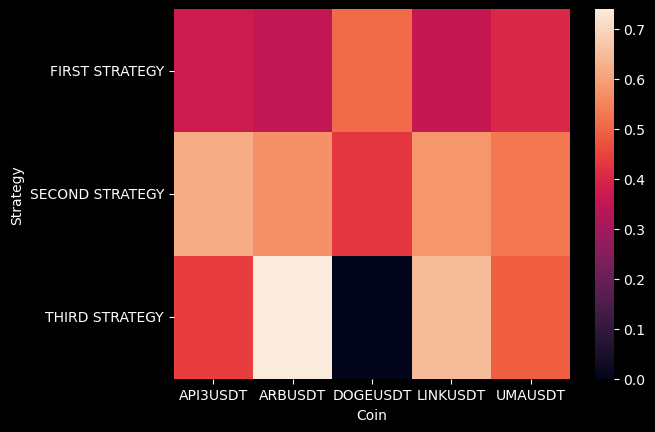

In [1642]:
sns.heatmap(df_test_)

*It is fascinating that the third strategy on DOGECOIN did not yield any positive trades.*  

*For a moment, that's 42 unprofitable trades out of 42 trades.*

In [1643]:
df_test = df_test.groupby(['Strategy'])['%'].mean().reset_index().sort_values(by = '%', ascending=False)
df_test

,Strategy,%
2,THIRD STRATEGY,0.580
1,SECOND STRATEGY,0.546
0,FIRST STRATEGY,0.398


*It's indeed very interesting that the first strategy has the lowest win percentage, but it ranks the highest in terms of earnings. On the other hand, the second and third strategies display the highest win percentage but the lowest earnings.*

*Do you know why this is the case? It's because in the first strategy, the ratio of stop-loss to take-profit is 1:2, while in the third strategy, it's only 1:1 :D*

### **The mathematical expectation of the strategies.**


*And now, it could be interesting to look at the mathematical expectation because we can see if the strategy is profitable in the long run.*

In [1670]:
df_test = df.groupby(['Strategy', 'Coin', 'Result'])[['Open_price', 'Close_price']].agg(['mean', 'count']).reset_index()
df_test['Mean Price'] = df_test['Open_price']['mean'] + df_test['Close_price']['mean']
df_test['Count'] = df_test['Open_price']['count']
df_test['Overall value'] = df_test.groupby(['Strategy', 'Coin'])['Count'].transform('sum')
df_test['%'] = np.round(df_test['Count']/df_test['Overall value'], 2)
df_test = df_test.drop(columns = ['Open_price', 'Close_price', 'Count', 'Overall value'])
df_test['Avg trade/%'] = df_test['Mean Price'] * df_test['%']
df_test['Math expectation'] = df_test.groupby(['Strategy', 'Coin'])['Avg trade/%'].transform('sum')
df_test = df_test[df_test.index % 2 == 1]
df_test_ = pd.pivot_table(df_test, index = 'Strategy', columns = 'Coin', values = 'Math expectation', fill_value=0)
df_test_

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_17372\517538529.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_test = df_test.drop(columns = ['Open_price', 'Close_price', 'Count', 'Overall value'])
C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_17372\517538529.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_test_ = pd.pivot_table(df_test, index = 'Strategy', columns = 'Coin', values = 'Math expectation', fill_value=0)


Coin             API3USDT   ARBUSDT  DOGEUSDT  LINKUSDT   UMAUSDT
Strategy                                                         
FIRST STRATEGY  -0.000455  0.000475  0.000010  0.002917 -0.002803
SECOND STRATEGY  0.002373 -0.000801 -0.000068 -0.004907 -0.005855
THIRD STRATEGY  -0.001463  0.000679  0.000000  0.002570 -0.020616

<Axes: xlabel='None-Coin', ylabel='Strategy'>

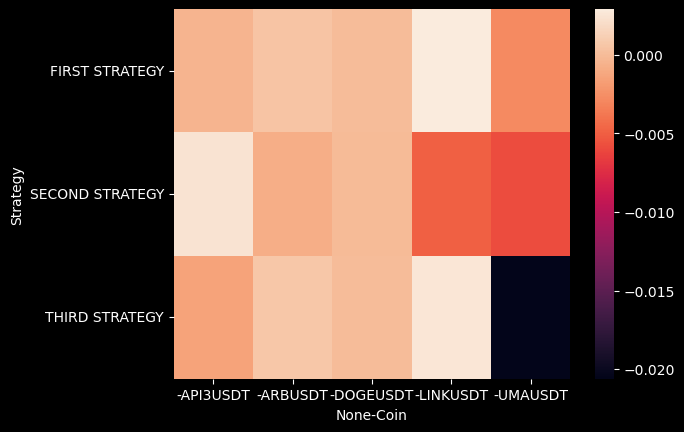

In [1645]:
sns.heatmap(df_test_)

In [1646]:
df_test = df_test.groupby(['Strategy'])['Math expectation'].sum().reset_index().sort_values(by = 'Math expectation', ascending = False)
df_test

,Strategy,Math expectation
0,FIRST STRATEGY,0.000144
1,SECOND STRATEGY,-0.009258
2,THIRD STRATEGY,-0.018830


*The mathematical expectation for the first strategy tends toward zero; I wouldn't rely on it.*

*Other strategies show a negative mathematical expectation, indicating that they don't work.*

### **A/B testing**

*Alright, let me start by telling you the changes I made to the strategies.*

#### **Regarding the improvements made to the strategies:**

**First strategy**

*The number of candles with identical highs has been increased from two candles to three candles.*

*A trend has been added, and trades will now be opened in the direction of that trend.*

**Second strategy**

*The average candle volume at the entry point has been increased from 1.5 to 2.*

*The stop loss for a trade has been increased by 1.5 times.*

**Third strategy**

*The difference in candle absorption has been increased from 1.25 to 1.5.*

*A trend has been added, and trades will now be opened in the direction of that trend.*

#### **Main hypothesis:**

*The improved strategies will show results in profit more than 1.25 times higher than the original strategies.*

#### **Preprocessing of data before analysis.**

*Reading an xlsx file.*

In [1647]:
df_b_test = pd.read_excel("B Test Bybit Data.xlsx")

*We do the same as with the first dataframe.*

In [1648]:
df_b_test = strip_spaces(df_b_test)
df_b_test = df_b_test.drop('Order_id', axis=1)

df_b_test_open_position = df_b_test[df_b_test['Order_type'] == 'OPEN']
df_b_test_close_position = df_b_test[df_b_test['Order_type'] == 'CLOSE']

df_b_test_open_position = df_b_test_open_position.drop('None.3', axis = 1)
df_b_test_open_position =df_b_test_open_position.rename(columns={'None': 'Price', 'None.1': 'Date', 'None.2': 'Time'})
df_b_test_close_position = df_b_test_close_position.rename(columns={'None': 'Tp/Sl', 'None.1': 'Price', 'None.2': 'Date', 'None.3': 'Time'})


df_b_test_open_position = to_main_format(df_b_test_open_position)
df_b_test_close_position = to_main_format(df_b_test_close_position)

df_b_test = all_strategies(df_b_test_open_position, df_b_test_close_position)

df_b_test = df_b_test.drop(columns=['row_num', 'Num_strategy_y', 'Coin_y', 'Date_y', 'Order_type_x', 'Order_type_y'])
df_b_test = df_b_test[['Num_strategy_x', 'Coin_x', 'Date_x', 'Side_x', 'Price_x','Time_x', 'Side_y', 'Price_y', 'Time_y', 'Tp/Sl']]
df_b_test.columns = ['Strategy','Coin','Date','Open_side','Open_price','Open_time', 'Close_side', 'Close_price', 'Close_time', 'Result']

df_b_test = to_correct_price(df_b_test, 'Open_side', 'Open_price')
df_b_test = to_correct_price(df_b_test, 'Close_side', 'Close_price')
df_b_test = to_correct_result(df_b_test)

df_b_test['Profit'] = df_b_test['Open_price'] + df_b_test['Close_price']

df_b_test.head(5)

,Strategy,Coin,Date,Open_side,Open_price,Open_time,Close_side,Close_price,Close_time,Result
0,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.338,13:29:08,SELL,6.3580,13:29:50,TAKE PROFIT
1,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.073,14:01:07,SELL,6.0930,14:01:27,TAKE PROFIT
2,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,5.823,14:30:10,SELL,5.8430,14:30:31,TAKE PROFIT
3,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,5.812,14:36:03,SELL,5.8320,14:36:35,TAKE PROFIT
4,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,5.901,14:44:03,SELL,5.9210,14:44:13,TAKE PROFIT
5,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.142,14:48:01,SELL,6.0783,14:49:24,STOP LOSS
6,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.082,14:54:07,SELL,6.0743,14:54:07,STOP LOSS
7,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.002,14:57:04,SELL,5.9999,14:57:04,STOP LOSS
8,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.017,15:04:01,SELL,6.0370,15:04:22,TAKE PROFIT
9,THIRD STRATEGY,UMAUSDT,2024-01-23,BUY,6.201,15:11:35,SELL,6.1478,15:13:18,STOP LOSS


### **Analysis of the dataframe.**

*We can also look at the distribution of the number of trades among the strategies.*

(array([166.,   0., 144.,   0.,   2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

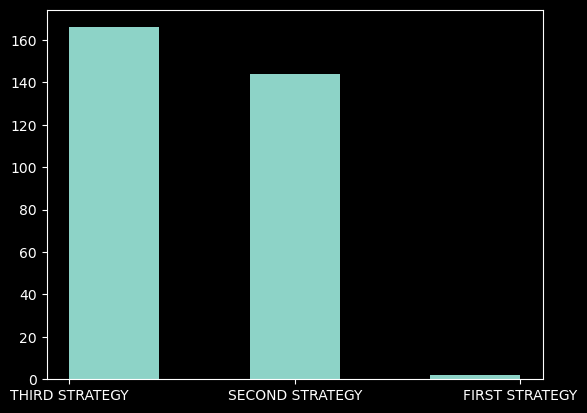

In [1649]:
plt.hist(df_b_test['Strategy'], bins = 5)

*This time, the first strategy made only 4 trades over the past few days, and they were unprofitable. We won't consider it in our calculations.*

*In terms of trades, the third strategy is leading this time.*

#### **Statistical significance**

*Statistical significance can indicate how much the mean values of the dataframes differ from each other.*

In [1651]:
def preprocessing_for_t_test(data):
    data1 = data[data['Strategy'] == 'SECOND STRATEGY']['Profit']
    data2 = data[data['Strategy'] == 'THIRD STRATEGY']['Profit']
    return data1, data2

In [1652]:
df_a_second_strategy,df_a_third_strategy = preprocessing_for_t_test(df)
df_b_second_strategy,df_b_third_strategy = preprocessing_for_t_test(df_b_test)

In [1653]:
def t_test(data1, data2):
    alpha = 0.05
    t_value, p_value = stats.ttest_ind(data1, data2)
    
    print(f'Test statistic is {t_value}' )
    print(f'p-value for two tailed test is {p_value}')

    if p_value <= alpha:
        print('We reject the null hypothesis; Mean significantly differs.\n')
    else:
        print('We accept the null hypothesis; Mean insignificantly differs.\n')

t_test(df_a_second_strategy,df_b_second_strategy)
t_test(df_a_third_strategy, df_b_third_strategy)

Test statistic is 0.11537713633478965
p-value for two tailed test is 0.9081777135275135
We accept the null hypothesis; Mean insignificantly differs.

Test statistic is -0.8209582422400636
p-value for two tailed test is 0.4121754664017888
We accept the null hypothesis; Mean insignificantly differs.



#### **Profit of the strategies.**

*Let's proceed to the most interesting part and observe the variations in earnings between the strategies.*

In [1654]:
def check_profit(data):
    data = data.groupby(['Strategy', 'Coin'])['Profit'].sum().reset_index()
    data = data[((data['Coin']=='UMAUSDT') | (data['Coin']=='ARBUSDT')) & (data['Strategy']!='FIRST STRATEGY')]
    return data

In [1682]:
df_b_test_profit = check_profit(df_b_test)
df_a_test_profit = check_profit(df)

df_a_b_test_profit = df_a_test_profit.merge(df_b_test_profit, on = ['Strategy', 'Coin'], suffixes= ('_A_test', '_B_test'))
strategies = df_a_b_test_profit.groupby(['Strategy'])[['Profit_A_test', 'Profit_B_test']].sum().reset_index()

print('Second strategy. A difference of ',np.round(strategies.loc[0]['Profit_A_test']/strategies.loc[0]['Profit_B_test'],2),' times')
print('Third strategy. A difference of ',np.round(strategies.loc[1]['Profit_A_test']/strategies.loc[1]['Profit_B_test'],2),' times')
df_a_b_test_profit

Second strategy. A difference of  2.42  times
Third strategy. A difference of  14.29  times


,Strategy,Coin,Profit_A_test,Profit_B_test
0,SECOND STRATEGY,ARBUSDT,-0.09110,0.02750
1,SECOND STRATEGY,UMAUSDT,-0.70400,-0.35600
2,THIRD STRATEGY,ARBUSDT,0.03102,0.01058
3,THIRD STRATEGY,UMAUSDT,-0.73570,-0.05990


*Now, that's a different story! The improved strategies performed much better than the standard ones.*

*The differences in the third strategy are quite significant; I would approach them with caution. Perhaps more trades are needed for a proper analysis of this strategy.*

*For the second strategy, this is an excellent result!*

#### **Percentage of profitable trades.**


*Now let's look at the percentage of profitable trades.*

In [1656]:
def tp_percent(data):
    data = data.groupby(['Strategy', 'Coin', 'Result'])['Profit'].count().reset_index()
    data['Overall count'] = data.groupby(['Strategy', 'Coin'])['Profit'].transform('sum').reset_index()['Profit']
    data = data[(data['Result'] == 'TAKE PROFIT') & (data['Strategy'] != 'FIRST STRATEGY') & ((data['Coin'] == 'ARBUSDT') | (data['Coin'] == 'UMAUSDT'))]
    data['TP %'] = data['Profit']/data['Overall count']
    return data[['Strategy', 'Coin', 'TP %']]


In [1657]:
df_b_test_tp_procent = tp_percent(df_b_test)
df_a_test_tp_procent = tp_percent(df)

df_a_test_tp_procent.merge(df_b_test_tp_procent, on = ['Strategy', 'Coin'], suffixes=(' | A_test', ' | B_test'))

,Strategy,Coin,TP % | A_test,TP % | B_test
0,SECOND STRATEGY,ARBUSDT,0.570175,0.524272
1,SECOND STRATEGY,UMAUSDT,0.525862,0.585366
2,THIRD STRATEGY,ARBUSDT,0.739130,0.544118
3,THIRD STRATEGY,UMAUSDT,0.485714,0.408163


*However, this is quite unclear.*

*It's a very interesting result for analysis because our success ratios are approximately equal, but the profit differs significantly.*

*You might ask: What's the reason? And I would answer: it lies in the ratio of take profit and stop loss of the strategies.*

#### **Ratio of the strategies.**

*The ratio of take profit to stop loss will show us with what ratio we are trading.*

In [1658]:
def join(data):
    data1 = data[data['Result'] == 'STOP LOSS'].copy()
    data1['Profit'] = data1['Profit'].apply(lambda x: abs(x))
    data2 = data[data['Result'] == 'TAKE PROFIT']
    data = data1.merge(data2, on = ['Strategy', 'Coin'])
    return data

def ratio_column(data):
    data['Ratio'] = np.round(data["Profit_y"]/data["Profit_x"],2)
    data['Ratio'] = data['Ratio'].astype(str)
    data['Ratio'] = "1 : " + data['Ratio']
    data = data[['Strategy', 'Coin', 'Ratio']]
    return data

def preprocessing_for_ratio(data):
    data = data.groupby(['Strategy', 'Coin', 'Result'])['Profit'].mean().reset_index()
    data = data[(data['Strategy']!='FIRST STRATEGY') & ((data['Coin'] == 'ARBUSDT') | (data['Coin'] == 'UMAUSDT'))]
    return data

def to_ratio_table(data):
    data = preprocessing_for_ratio(data)
    data = join(data)
    data = ratio_column(data)
    return data

In [1659]:
df_a_test_ratio = to_ratio_table(df)
df_b_test_ratio = to_ratio_table(df_b_test)

df_a_test_ratio.merge(df_b_test_ratio, on = ['Strategy', 'Coin'], suffixes=('_A_test', '_B_test'))

,Strategy,Coin,Ratio_A_test,Ratio_B_test
0,SECOND STRATEGY,ARBUSDT,1 : 0.51,1 : 1.01
1,SECOND STRATEGY,UMAUSDT,1 : 0.55,1 : 0.39
2,THIRD STRATEGY,ARBUSDT,1 : 0.66,1 : 0.98
3,THIRD STRATEGY,UMAUSDT,1 : 0.41,1 : 1.34


*As you can see, in test A, the approximate ratio is 1:0.5, while in test B, the ratio is 1:1.*

*In the first case, this means that for every losing trade, there is half a winning trade.*

*In other words, we lose one ruble and gain 50 pennys.*

*In the second case, we lose one ruble and gain one ruble, which means that if our percentage of profitable trades is above 50%, we will be profitable.*

### **Results of the Project**

**1. Profit of Standard Strategies:** *The overall profit of standard strategies is negative.*

**2. Lowest Monetary Loss:** *The first strategy demonstrated the lowest monetary loss among all strategies.*

**3. Highest Percentage of Positive Trades:** *The third strategy exhibited the highest percentage of positive trades, indicating a potential strength in trade selection.*

**4. Stability Concerns for the Third Strategy:** *Despite its success rate, the third strategy displayed significant instability. Further scrutiny is advised, especially considering zero positive trades for DOGE out of 42 and 74% positive trades out of 46 for ARBUSDT.*

**5. Perspective on Standard Strategies:** *Standard strategies are projected to incur losses over time.*

**6. Expected Values:** *The expected values for the second and third strategies are negative, while the first strategy hovers close to zero. This suggests that even the seemingly profitable first strategy may incur losses in the long run.*

**7. Performance of First Improved Strategy:** *The first improved strategy, implemented over 30 hours, executed only four trades, all of which were unprofitable.*

**8. Profit Difference between Standard and Improved Strategies:** *The profit of improved strategies is 2.5 times higher than that of standard strategies.*

**9. Similar Positive Trade Percentages:** *Although the percentage of positive trades is similar, improved strategies outperformed due to a favorable take-profit-to-stop-loss ratio.*

### **Suggestions for increasing results**

**1. Experimentation with Stop-Loss and Take-Profit Sizes:**
*Consider refining strategies through experimentation with stop-loss and take-profit sizes. The substantial impact of these parameters on profitability suggests a significant potential for optimization.*

**2. Reassessment of the First Strategy:**
*Revisit the first strategy and contemplate the inclusion of additional conditions, particularly those related to increased volume during position entry.*

**3. Precision Enhancement for the Second and Third Strategies:**
*Enhance the precision of the second and third strategies by introducing additional conditions. For the third strategy, this may involve increasing the number of candlesticks absorbed by the main candle for more accurate trade decisions. Additionally, consider augmenting the volume of candles during position entry for the second strategy.*